In [1]:
import os
import pandas as pd 

import re

In [20]:
df = pd.read_csv('mhc.gff3', sep='\t', header = None)

In [23]:
coords = df.loc[df[0]=='chr6', [0,3, 4]]

In [25]:
min = int(coords[3].min()) - 10000
max = int(coords[4].max()) + 10000

In [26]:
print(min, max)

29585529 32962695


In [1]:
loci = ['6732309', '6734752', '6751419', '6753858', '6770536', '6772968', '6690512', '6692998']

In [3]:
loci = [int(loc) for loc in loci]

In [4]:
min = min(loci) - 10000
max = max(loci) + 10000

In [6]:
print(min, max)

6680512 6782968


In [ ]:
import sys
walks_file = sys.argv[1]
graph_file = sys.argv[2]
walks = open(walks_file, 'r').read().splitlines()
region = open(graph_file, 'r').read().splitlines()
segments = set()
for r in region:
    if r[0] == 'S':
        segment = r.split('\t')[1]
        segments.add(segment)
sample_walks = {}
for walk in walks:
    items = walk.split('\t')
    sample_walks[items[1]] = []
    
for walk in walks:
    items = walk.split('\t')
    nodes = re.split(r'[><]', items[6].strip())
    sample_walks[items[1]].extend([node for node in nodes if node != '' ])
for k,v in sample_walks.items():
    sample_walks[k] = segments.intersection(set(v))
    
for k, v in sample_walks.items():
    with open(f'walks/{k}.walks', 'w') as f:
        for item in v:
            f.write(item + '\n')

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import gzip
from multiprocessing import Pool

In [9]:
with gzip.open('arp-v2.1-mc-chm13.vcf.gz', 'rt') as f:
    lines = [l for l in f if not l.startswith('##')]


In [10]:
new_lines = [line.split('\t') for line in lines]

In [11]:
df = pd.DataFrame(new_lines[1:], columns=new_lines[0]).rename(columns={'#CHROM': 'CHROM'})

In [12]:
df.columns

Index(['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT',
       'father', 'gp001', 'gp002', 'gp003', 'gp004', 'gp005', 'gp006', 'gp007',
       'gp008', 'gp009', 'gp010', 'gp011', 'gp012', 'gp013', 'gp014', 'gp015',
       'gp016', 'gp017', 'gp018', 'gp019', 'gp020', 'gp021', 'gp022', 'gp023',
       'gp024', 'gp025', 'gp026', 'gp027', 'gp029', 'gp030', 'gp031', 'gp032',
       'gp033', 'gp034', 'gp035', 'gp036', 'gp037', 'gp038', 'gp039', 'gp040',
       'gp041', 'hg38_no_alt', 'mother', 'son\n'],
      dtype='object')

In [14]:
pd.concat([df['CHROM'], df['POS']]).unique().shape

(18483260,)

In [17]:
df.shape

(19528944, 53)

In [18]:
with open('APR_All_SVs.vcf', 'r') as f:
    lines = [l for l in f if not l.startswith('##')]


In [19]:
new_lines = [line.split('\t') for line in lines]

In [20]:
df2 = pd.DataFrame(new_lines[1:], columns=new_lines[0]).rename(columns={'#CHROM': 'CHROM'})

In [21]:
pd.concat([df2['CHROM'], df2['POS']]).unique().shape

(80763,)

In [15]:
df.loc[df['LV']>5].shape

(2495, 54)

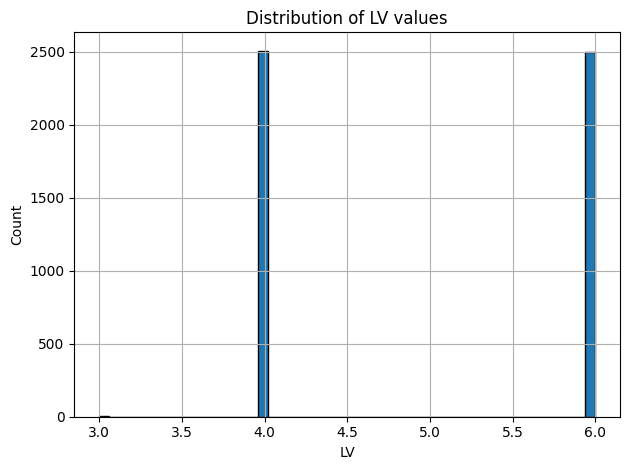

In [16]:
df['LV'] = df['INFO'].str.extract('LV=([\d]+)').astype(float)

# Plot distribution
plt.hist(df.loc[df['LV']>2, 'LV'].dropna(), bins=50, edgecolor='black')
plt.title('Distribution of LV values')
plt.xlabel('LV')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.show()

In [1]:
assembly_dir  = '/mnt/h700/omixlab/workflows/genome-project/assembly/pangenome/par_splitted_assemblies3/'

In [6]:
assemblies = ([f'/mnt/h700/omixlab/workflows/genome-project/assembly/pangenome/par_splitted_assemblies3/{file}' for file in os.listdir(assembly_dir) if file.split('.')[1]=='bp'])

In [8]:
for assembly in assemblies:
    sample = assembly.split('/')[-1].split('.')[0]
    hap = assembly.split('/')[-1].split('.')[2][-1]

    command = f'''#!/bin/bash
#SBATCH -p LocalQ
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=1
#SBATCH --cpus-per-task=40
#SBATCH --output=out/{sample}.std.out
#SBATCH --error=out/{sample}.std.err
#SBATCH --job-name={sample}.misjoin

/mnt/h700/omixlab/packages/bin/minigraph -cxasm -t 40 --call /mnt/h700/omixlab/workflows/genome-project/assembly/pangenome/arp.hifiasm.v2.1_all/analyse/arp-v2.1-mc-chm13.gfa.gz {assembly} > /mnt/h700/omixlab/workflows/genome-project/assembly/pangenome/arp.hifiasm.v2.1_all/analyse/assembly_calls/{sample}.{hap}.calls'''
    
    with open(f'sbatch_scripts/{sample}.{hap}.call.sh', 'w+') as f:
        f.write(command)

In [2]:
with open('large_SVs_5_alleles.vcf', 'rt') as f:
    lines = [l for l in f if not l.startswith('##')]
new_lines = [line.split('\t') for line in lines]

In [3]:
df = pd.DataFrame(new_lines[1:], columns=new_lines[0]).rename(columns={'#CHROM': 'CHROM'})

In [4]:
df.shape

(330, 53)

In [5]:
df = df[df['REF'].str.len() < df['ALT'].str.len()]

In [6]:
df

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,father,...,gp035,gp036,gp037,gp038,gp039,gp040,gp041,hg38_no_alt,mother,son\n
8,chr1,147822280,>3550013>3550071,AGAGAGAGAGAGAGGAGAAAGTGAGCTCAGCGAATTGGCCGGGTGA...,AGAGAGAGAGAGAGGAGAAAGTGAGCTCAGCGAATTGGCCGGGTGA...,60,.,AC=5;AF=0.0595238;AN=84;AT=>3550013>3550014>35...,GT,0|0,...,0|.,0|0,0|0,0|0,0|0,.|0,0|0,0,1|0,0|1\n
16,chr1,197766555,>4231389>4231568,C,CTATTTCAAGCTGATAACAACTTAACTTTAATCACATACCAAACTC...,60,.,"AC=5;AF=0.0574713;AN=87;AT=>4231389>4231568,>4...",GT,0|0,...,0|0,0|0,1|0,0|0,0|0,0|0,0|0,0,0|0,0|0\n
17,chr1,197766555,>4231389>4231568,C,CTATTTCAAGCTGATAACAACTTAACTTTAATCACATACCAAACTC...,60,.,"AC=6;AF=0.0689655;AN=87;AT=>4231389>4231568,>4...",GT,0|1,...,0|0,0|0,0|0,0|0,0|0,0|0,0|1,0,0|0,0|0\n
25,chr10,123480445,<6178346<6178748,T,TCCCAGTGGCCAACCCTTAGAGGTTTAGGAAGTGGCCTCATATTTA...,60,.,"AC=17;AF=0.195402;AN=87;AT=>6178748>6178346,>6...",GT,0|0,...,0|0,0|0,0|0,0|1,0|0,1|0,1|0,0,0|0,0|0\n
26,chr10,123480445,<6178346<6178748,T,TCCCAGTGGCCAACCCTTAGAGGTTTAGGAAGTGGCCTCATATTTA...,60,.,"AC=7;AF=0.0804598;AN=87;AT=>6178748>6178346,>6...",GT,0|0,...,1|0,0|0,1|0,0|0,1|1,0|0,0|0,0,0|0,0|0\n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312,chrX,78421264,>72690254>72690305,AAT,ACAGAACTCTCCACCCAAAAACAACAGAATATACATTTTTTTTCAG...,60,.,AC=5;AF=0.0724638;AN=69;AT=>72690254>72690255>...,GT,.|0,...,0|0,.|0,0|1,.|0,0|.,0|0,.|0,0,0|0,.|0\n
313,chrX,78421264,>72690254>72690305,AAT,ACAGAACTCTCCACCCAAAAACAACAGAATATACATTTTTTTTCAG...,60,.,AC=6;AF=0.0869565;AN=69;AT=>72690254>72690255>...,GT,.|0,...,0|0,.|0,0|0,.|1,0|.,0|0,.|0,0,0|0,.|0\n
314,chrX,114431248,>71276038>71275971,AGTTGCCATTTAGTATAATGTT,ATGTGTACAATGGCACAACCACTTTGTAAAAATAGTTTGGTAGTTT...,60,.,AC=8;AF=0.115942;AN=69;AT=>71276038>71275974>7...,GT,.|0,...,0|1,0|.,0|0,0|.,.|0,0|1,.|0,0,0|0,.|0\n
315,chrX,114431248,>71276038>71275971,AGTTGCCATTTAGTATAATGTT,ATGTGTACAATGGCACAACCACTTTGTAAAAATAGTTTGGTAGTTT...,60,.,AC=14;AF=0.202899;AN=69;AT=>71276038>71275974>...,GT,.|0,...,1|0,0|.,1|1,0|.,.|0,0|0,.|0,0,1|1,.|1\n


In [7]:
import os

In [8]:
for i, item in df.iterrows():
    command = f'gfabase sub /mnt/h700/omixlab/workflows/genome-project/assembly/pangenome/arp.hifiasm.v2.1_all/analyse/arp-v2.1-mc-chm13.full.gfab -o /mnt/h700/omixlab/workflows/genome-project/assembly/pangenome/arp.hifiasm.v2.1_all/analyse/sub-graphs/graphs/sub.{item["CHROM"]}.{item["POS"]}.{i}.gfa chm13v2#{item["CHROM"]}:{int(item["POS"]) - 500000}-{int(item["POS"]) + 500000} --range --cutpoints 2 --guess-ranges&'
    os.system(command)


[WARN][22.3s] excluding all Walks; including them requires --connected (and connectivity index)
[WARN][[22.] 33excluding all Walks; including them requires --connected (and connectivity index)m
WARN][22.3s] excluding all Walks; including them requires --connected (and connectivity index)
[WARN][22.8s] excluding all Walks; including them requires --connected (and connectivity index)
[WARN][22.8s] excluding all Walks; including them requires --connected (and connectivity index)
[INFO][23.2s] guessed ranges for 9265 segments
[INFO][23.2s] guessed ranges for 9265 segments
[INFO][23.4s] guessed ranges for 8827 segments
[WARN][23.7s] excluding all Walks; including them requires --connected (and connectivity index)
[WARN][23.7s] excluding all Walks; including them requires --connected (and connectivity index)
[INFO][23.9s] guessed ranges for 10353 segments
[INFO][23.9s] guessed ranges for 10353 segments
[WARN][24.1s] excluding all Walks; including them requires --connected (and connectivity i

In [8]:
def extract_genes_from_gff3(filename):
    genes = {}
    with open(filename, 'r') as gff:
        for line in gff:
            if not line.startswith("#"):  # Ignore comment lines
                parts = line.strip().split("\t")
                if parts[2] == "gene":
                    chrom = parts[0]
                    start = int(parts[3])
                    end = int(parts[4])
                    attributes = parts[8].split(";")
                    gene_name = None
                    for attribute in attributes:
                        if attribute.startswith("gene_name="):
                            gene_name = attribute.split("=")[1]
                            break
                    if gene_name:
                        if chrom not in genes:
                            genes[chrom] = []
                        genes[chrom].append((start, end, gene_name))
    return genes


In [9]:
def variants_within_flank(variants, genes, flank_size):
    result = {}
    
    for i,line in variants.iterrows():
        chrom = line['CHROM']
        pos = int(line['POS'])
        start_flank = pos - flank_size
        end_flank = pos + flank_size
        
        # Check if genes are within the flanking region
        for start, end, gene_name in genes.get(chrom, []):
                    if start < end_flank and end > start_flank:
                        key = (chrom, pos)
                        if key not in result:
                            result[key] = []
                        result[key].append(gene_name)
    return result

In [10]:

gff3_file = "chm13v2.0_RefSeq_Liftoff_v5.1.gff3"

genes = extract_genes_from_gff3(gff3_file)


In [11]:
result = variants_within_flank(df, genes, 500_000_000)

In [16]:
rows = [(key, val) for key, values in result.items() for val in values]

# Create a DataFrame
gene_df = pd.DataFrame(rows, columns=['loc', 'gene'])



In [19]:
!pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 2.2 MB/s eta 0:00:0000:0100:01


In [20]:
recessive_genes = pd.read_excel('Recessive genes_GA gene list.xlsx')

In [29]:
intersect = gene_df.merge(recessive_genes, how='left', left_on='gene', right_on='Gene Name').dropna().drop(['Gene Name'], axis=1)

In [31]:
intersect_dict = {}
for i, row in intersect.iterrows():
    if row['loc'] not in intersect_dict:
        intersect_dict[row['loc']] = [] 
    intersect_dict[row['loc']].append(str(row['gene']))

In [33]:
intersect.to_csv('gene_recessive_intersection.csv', index= None)

In [38]:
intersect.groupby('loc').count().sort_values('gene', ascending=False).to_csv('count_recessive.csv', index=None)

In [32]:
intersect_dict

{('chr1', 147822280): ['ISG15',
  'AGRN',
  'TNFRSF4',
  'B3GALT6',
  'VWA1',
  'PEX10',
  'TP73',
  'CEP104',
  'NPHP4',
  'PLEKHG5',
  'PARK7',
  'SLC45A1',
  'H6PD',
  'NMNAT1',
  'PEX14',
  'MASP2',
  'MAD2L2',
  'MTHFR',
  'PLOD1',
  'VPS13D',
  'ATP13A2',
  'PADI3',
  'PADI6',
  'PAX7',
  'ALDH4A1',
  'EMC1',
  'PLA2G5',
  'PINK1',
  'DDOST',
  'C1QA',
  'C1QC',
  'C1QB',
  'EPHB2',
  'GALE',
  'HMGCL',
  'FUCA1',
  'LDLRAP1',
  'SELENON',
  'PIGV',
  'SLC9A1',
  'TMEM222',
  'FCN3',
  'EPB41',
  'MECR',
  'LCK',
  'YARS1',
  'HPCA',
  'AK2',
  'ADPRS',
  'CSF3R',
  'SNIP1',
  'RSPO1',
  'TRIT1',
  'MFSD2A',
  'PPT1',
  'COL9A2',
  'CTPS1',
  'PPCS',
  'CLDN19',
  'P3H1',
  'SVBP',
  'SZT2',
  'PTPRF',
  'ST3GAL3',
  'SLC6A9',
  'RNF220',
  'TMEM53',
  'EIF2B3',
  'HPDL',
  'MUTYH',
  'TOE1',
  'POMGNT1',
  'STIL',
  'ORC1',
  'COA7',
  'SCP2',
  'CPT2',
  'PARS2',
  'DHCR24',
  'BSND',
  'C8A',
  'C8B',
  'TACSTD2',
  'DOCK7',
  'ANGPTL3',
  'ALG6',
  'PGM1',
  'ROR1',
  'DNAJC6

In [22]:
from Bio import SeqIO
def extract_sequence(reference_file,gene_name, chrom, start, end):
    """Extract sequence from reference FASTA file given coordinates."""
    for record in SeqIO.parse(reference_file, "fasta"):
        if record.id == chrom:
            return (gene_name, record.seq[start-1:end])
    return None



In [17]:
reference_fasta='/mnt/h700/omixlab/workflows/genome-project/resources/chm13v2.0.fa'

In [18]:
tasks = []
for (chrom, pos), overlapping_genes in result.items():
    # output_filename = f"gene_fastas/sub.{chrom}.{pos}.fa"
    # with open(output_filename, 'w') as output_fasta:
    for start, end, gene_name in genes.get(chrom, []):
        if gene_name in overlapping_genes:
            extraction_task = (reference_fasta, gene_name, chrom, start, end)
            tasks.append(extraction_task)
            # if sequence:
            #     output_fasta.write(f">{gene_name}\n{sequence}\n")

In [22]:
with Pool() as p:
    p.starmap(extract_sequence, tasks)

In [3]:
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

def extract_genes_from_gff3(gff3_file, chr_name, start, end):
    genes = []
    
    with open(gff3_file, 'r') as file:
        for line in file:
            if not line.startswith("#"):  # Skip comments
                parts = line.strip().split("\t")
                if len(parts) > 8:
                    seqname, source, feature_type, start_pos, end_pos, score, strand, frame, attributes = parts
                    if seqname == chr_name and feature_type == "gene_name" and int(start_pos) >= start and int(end_pos) <= end:
                        genes.append((seqname, int(start_pos), int(end_pos), attributes))
                        
    return genes

def extract_sequences_from_fasta(fasta_file, genes):
    sequences = []
    
    fasta_dict = SeqIO.to_dict(SeqIO.parse(fasta_file, "fasta"))
    for gene in genes:
        gene_name, start, end = gene
        gene_seq = fasta_dict['chr6'].seq[start-1:end]
        record = (gene_name, str(gene_seq).capitalize())
        sequences.append(record)

    return sequences



In [4]:
gff3_file = "chm13v2.0_RefSeq_Liftoff_v5.1.gff3"
fasta_file = "/mnt/h700/omixlab/workflows/genome-project/resources/chm13v2.0.fa"
output_file = "chr6_genes_sequences.fasta"

genes = extract_genes_from_gff3(gff3_file, "chr6", 29585529, 32962695)


0

In [24]:
sequences = extract_sequences_from_fasta(fasta_file, genes)

with open(output_file, "w") as output_handle:
    SeqIO.write(sequences, output_handle, "fasta")

NameError: name 'fasta_file' is not defined

In [5]:
def extract_genes_from_region(filename, chrom_filter, start_filter, end_filter):
    genes = {}
    with open(filename, 'r') as gff:
        for line in gff:
            if not line.startswith("#"):  # Ignore comment lines
                parts = line.strip().split("\t")
                chrom = parts[0]
                start = int(parts[3])
                end = int(parts[4])
                
                # Filter for the specific region
                if chrom == chrom_filter and parts[2] == "gene" and start_filter <= start and end_filter >= end:
                    attributes = parts[8].split(";")
                    gene_name = None
                    for attribute in attributes:
                        if attribute.startswith("gene_name="):
                            gene_name = attribute.split("=")[1]
                            break
                    if gene_name:
                        if chrom not in genes:
                            genes[chrom] = []
                        genes[chrom].append((start, end, gene_name))
    return genes

# Usage
filename = "chm13v2.0_RefSeq_Liftoff_v5.1.gff3"
chrom_filter = "chr6"
start_filter = 29585529
end_filter = 32962695
genes_in_region = extract_genes_from_region(filename, chrom_filter, start_filter, end_filter) 

In [7]:
len(genes_in_region['chr6'])

273

In [43]:
def extract_protein_coding_genes_from_region(filename, chrom_filter, start_filter, end_filter):
    genes = []
    with open(filename, 'r') as gff:
        for line in gff:
            if not line.startswith("#"):  # Ignore comment lines
                parts = line.strip().split("\t")
                chrom = parts[0]
                start = int(parts[3])
                end = int(parts[4])
                
                # Filter for the specific region
                if chrom == chrom_filter and parts[2] == "gene" and start_filter <= start and end_filter >= end:
                    attributes = parts[8].split(";")
                    gene_name = None
                    is_protein_coding = False
                    for attribute in attributes:
                        if attribute.startswith("gene_name="):
                            gene_name = attribute.split("=")[1]
                        if attribute == "gene_biotype=protein_coding":
                            is_protein_coding = True

                    if gene_name and is_protein_coding:
                        
                        genes.append((chrom,start, end, gene_name))

    return genes

In [44]:
filename = "chm13v2.0_RefSeq_Liftoff_v5.1.gff3"
chrom_filter = "chr6"
start_filter = 29585529
end_filter = 32962695
genes_in_region = extract_protein_coding_genes_from_region(filename, chrom_filter, start_filter, end_filter) 

In [8]:
def extract_sequences_from_fasta(fasta_file, genes):
    sequences = []
    
    fasta_dict = SeqIO.to_dict(SeqIO.parse(fasta_file, "fasta"))
    for gene in genes:
        chrom,start, end, gene_name = gene
        gene_seq = fasta_dict['chr6'].seq[start-1:end]
        record = (gene_name, str(gene_seq).upper())
        sequences.append(record)

    return sequences


In [13]:
interesting_genes = [gene for gene in genes_in_region['chr6'] if 'HLA' in gene[2]]

In [14]:
len(interesting_genes)

39

In [18]:
gene_sequences = extract_sequences_from_fasta(fasta_file, interesting_genes)

In [19]:
gene_sequences

[('HLA-F',
  'ATATTTTTCCCAGACGCGGAGGTTGGGGTCATGGCGCCCCGAAGCCTCCTCCTGCTGCTCTCAGGGGCCCTGGCCCTGACCGATACTTGGGCGGGTGAGTGCGGGGTCCAGAGAGAAACGGCCTCTGTGGGGAGGAGTGAGGGGCCCGCCCGGTGGGGGCGCAGGACTCAGGGAGCCGCGCCCGGAGGAGGGTCTGGCGGGTCTCAGCCCCTCCTCGCCCCCAGGCTCCCACTCCTTGAGGTATTTCAGCACCGCTGTGTCGCGGCCCGGCCGCGGGGAGCCCCGCTACATCGCCGTGGAGTACGTAGACGACACGCAATTCCTGCGGTTCGACAGCGACGCCGCGATTCCGAGGATGGAGCCGCGGGAGCCGTGGGTGGAGCAAGAGGGGCCGCAGTATTGGGAGTGGACCACAGGGTACGCCAAGGCCAACGCACAGACTGACCGAGTGGCCCTGAGGAACCTGCTCCGCCGCTACAACCAGAGCGAGGCTGGTGAGTGAACCCGGCCGGGGGCGCAGGTCACGACCACCCCCCATCCGCCACGGACCGCCCGGGTCCCTCAGAGTCTCCGGATCCGAAATCTACCCCGAGGCAGCGGGACCCGCCCAGACCCTCCACCCGGGAGAGTCCCAGGCGCCTTTACCCAGGTTCATTTTCAGTTTAGGCCAAAATCCCCGCGGGTTGGGCGGGGAGGGGGCGGGGCTAGCTGGGCGGGGCTGACTGCGGGGACCGGCTAGGGTCTCACACCCTCCAGGGAATGAATGGCTGCGACATGGGGCCCGACGGACGCCTCCTCCGCGGGTATCACCAGCACGCGTACGACGGCAAGGATTACATCTCCCTGAACGAGGACCTGCGCTCCTGGACCGCGGCGGACACCGTGGCTCAGATCACCCAGCGCTTCTATGAGGCAGAGGAATATGCAGAGGAGTTCAGGACCTACCTGGAGGGCGAGTGCCTGGAGTTGCTCCGCAGATACTTGGA

In [20]:
with open('mhc_hla_gene_regions_protien_coding.fasta', 'w+') as f:
    for gene, sequence in gene_sequences:
        f.write(f'>{gene}\n{sequence}\n')

In [53]:
with open('gene_names.csv', 'w+') as f:
    [f.write(f'{gene[0]}\n') for gene in gene_sequences]

In [50]:
import re
import random

In [24]:
df = pd.read_csv('aligned_mhc.gaf', sep='\t', header=None)

In [52]:
def random_color():
    return "#%06x" % random.randint(0, 0xFFFFFF)

In [53]:
df['color'] = df.apply(lambda x: random_color(), axis=1)

In [58]:
items=[]
for i, row in df.iterrows():

    nodes = re.split(r'[<>]',row[5])
    
    for node in nodes:
        if node != '':
            items.append((node, row['color']))

In [61]:
pd.DataFrame(items).to_csv('hla_colors.csv', header=None, index=None)

In [46]:
paths = []
for nodes in df[5]:
    paths.extend(re.split(r'[><]', nodes))

In [48]:
','.join(paths)

',58994966,58994968,58994969,58994971,58994972,58994974,58994975,58994977,58994978,58994980,58994981,58994983,58994984,58994986,58994987,58994989,58994990,58994991,58994993,58994995,58994996,58994998,58994999,58995001,58995002,58995004,58995005,58995007,58995008,58995010,58995011,58995013,58995014,58995015,58995017,58995018,58995020,58995021,58995023,58995025,58995026,58995028,58995029,58995031,58995032,58995034,58995035,58995037,58995038,58995040,58995041,58995043,58995044,58995046,58995047,58995049,58995050,58995052,58995053,58995054,58995056,58995058,58995060,58995061,58995063,58995064,58995065,58995067,58995069,58995070,58995072,58995074,58995075,58995077,58995078,58995080,58995081,58995083,58995084,58995086,58995087,58995089,58995090,58995091,58995093,58995095,58995096,58995097,58995098,58995100,58995101,58995103,58995104,58995105,58995107,58995108,58995110,58995112,58995113,58995116,58995117,58995118,58995119,58995121,58995123,58995124,58995125,58995127,58995129,58995130,58995132

In [38]:
','.join(re.split(r'[<>]',(df.loc[df[0]=='HLA-T', 5])[0]))

',58994966,58994968,58994969,58994971,58994972,58994974,58994975,58994977,58994978,58994980,58994981,58994983,58994984,58994986,58994987,58994989,58994990,58994991,58994993,58994995,58994996,58994998,58994999,58995001,58995002,58995004,58995005,58995007,58995008,58995010,58995011,58995013,58995014,58995015,58995017,58995018,58995020,58995021,58995023,58995025,58995026,58995028,58995029,58995031,58995032,58995034,58995035,58995037,58995038,58995040,58995041,58995043,58995044,58995046,58995047,58995049,58995050,58995052,58995053,58995054,58995056,58995058,58995060,58995061,58995063,58995064,58995065,58995067,58995069,58995070,58995072,58995074,58995075,58995077,58995078,58995080,58995081,58995083,58995084,58995086,58995087,58995089,58995090,58995091,58995093,58995095,58995096,58995097,58995098,58995100,58995101,58995103,58995104,58995105,58995107,58995108,58995110,58995112,58995113,58995116,58995117,58995118,58995119,58995121,58995123,58995124,58995125,58995127,58995129,58995130,58995132

In [2]:
import requests
import xml.etree.ElementTree as ET

def get_chromosome_name(accession):
    base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils"
    
    search_response = requests.get(f"{base_url}/esearch.fcgi?db=nucleotide&term={accession}&retmode=xml")
    root = ET.fromstring(search_response.content)
    uid = root.find("IdList/Id").text
    
    fetch_response = requests.get(f"{base_url}/efetch.fcgi?db=nucleotide&id={uid}&retmode=xml")
    root = ET.fromstring(fetch_response.content)
    organism = root.find(".//OrgName_lineage")
    
    return organism.text if organism is not None else "Unknown"

def extract_unique_locations(gff_file):
    locations = set()

    with open(gff_file, 'r') as infile:
        for line in infile:
            if not line.startswith("#"):
                locations.add(line.split("\t")[0])

    return locations

def process_gff_file(input_gff, output_gff, mappings):
    with open(input_gff, 'r') as infile, open(output_gff, 'w') as outfile:
        for line in infile:
            if not line.startswith("#"):
                parts = line.split("\t")
                parts[0] = mappings.get(parts[0], parts[0])
                outfile.write("\t".join(parts))
            else:
                outfile.write(line)
# Paths to your files
input_gff_path = "cat/genomic.gff"
output_gff_path = "chm13_genomic_chr_exon.gff3"

unique_locations = extract_unique_locations(input_gff_path)
location_to_name_mapping = {loc: get_chromosome_name(loc) for loc in unique_locations}

process_gff_file(input_gff_path, output_gff_path, location_to_name_mapping)

ParseError: not well-formed (invalid token): line 1, column 0 (<string>)

In [3]:
unique_locations = sorted(list(unique_locations))

In [21]:
output_gff_path = "chm13_genomic_chm13_chr1.gff3"

In [22]:
import numpy as np
chrs = [f'chm13v2#chr{i+1}' for i in np.arange(22)]

In [23]:
chrs.append('chm13v2#chrX')
chrs.append('chm13v2#chrY')


In [24]:
chrs

['chm13v2#chr1',
 'chm13v2#chr2',
 'chm13v2#chr3',
 'chm13v2#chr4',
 'chm13v2#chr5',
 'chm13v2#chr6',
 'chm13v2#chr7',
 'chm13v2#chr8',
 'chm13v2#chr9',
 'chm13v2#chr10',
 'chm13v2#chr11',
 'chm13v2#chr12',
 'chm13v2#chr13',
 'chm13v2#chr14',
 'chm13v2#chr15',
 'chm13v2#chr16',
 'chm13v2#chr17',
 'chm13v2#chr18',
 'chm13v2#chr19',
 'chm13v2#chr20',
 'chm13v2#chr21',
 'chm13v2#chr22',
 'chm13v2#chrX',
 'chm13v2#chrY']

In [25]:
mappings = {i:z for i,z in zip(unique_locations, chrs)}

In [26]:
def process_gff_file(input_gff, output_gff, mappings):
    with open(input_gff, 'r') as infile, open(output_gff, 'w') as outfile:
        for line in infile:
            if not line.startswith("#"):
                parts = line.split("\t")
                
                parts[0] = mappings.get(parts[0])
                parts[8] = parts[8].split(';')[-1]
                
                outfile.write("\t".join(parts))
            else:
                outfile.write(line)

In [27]:
output_gff_path

'chm13_genomic_chm13_chr1.gff3'

In [20]:
process_gff_file(input_gff_path, output_gff_path, mappings)

In [3]:
import re

In [8]:
','.join(re.split(r'[<>]',
' <65565471<65565469<65565468<65565466<65565465<65565463<65565462<65565460<65565459<65565458<65565456<65565454<65565453<65565452<65565450>65565448<65565447<65565445<65565444<65565442<65565441<65565439<65565438<65565436<65565434<65565433<65565432<65565431<65565428<65565427<65565426<65565424<65565423<65565422<65565420<65565418<65565417<65565416<65565414<65565412<65565411<65565409<65565408<65565407<65565405<65565403<65565402'
))

' ,65565471,65565469,65565468,65565466,65565465,65565463,65565462,65565460,65565459,65565458,65565456,65565454,65565453,65565452,65565450,65565448,65565447,65565445,65565444,65565442,65565441,65565439,65565438,65565436,65565434,65565433,65565432,65565431,65565428,65565427,65565426,65565424,65565423,65565422,65565420,65565418,65565417,65565416,65565414,65565412,65565411,65565409,65565408,65565407,65565405,65565403,65565402'

In [30]:
mappings

{'NC_060925.1': 'chr1',
 'NC_060926.1': 'chr2',
 'NC_060927.1': 'chr3',
 'NC_060928.1': 'chr4',
 'NC_060929.1': 'chr5',
 'NC_060930.1': 'chr6',
 'NC_060931.1': 'chr7',
 'NC_060932.1': 'chr8',
 'NC_060933.1': 'chr9',
 'NC_060934.1': 'chr10',
 'NC_060935.1': 'chr11',
 'NC_060936.1': 'chr12',
 'NC_060937.1': 'chr13',
 'NC_060938.1': 'chr14',
 'NC_060939.1': 'chr15',
 'NC_060940.1': 'chr16',
 'NC_060941.1': 'chr17',
 'NC_060942.1': 'chr18',
 'NC_060943.1': 'chr19',
 'NC_060944.1': 'chr20',
 'NC_060945.1': 'chr21',
 'NC_060946.1': 'chr22',
 'NC_060947.1': 'chrX',
 'NC_060948.1': 'chrY'}